Dataset loaded successfully!
Dataset shape: (10000, 9)

First 5 rows of the dataset:
   Unit Weight (kN/m³)  Cohesion (kPa)  Internal Friction Angle (°)  \
0            18.745401       21.813837                    38.249958   
1            24.507143       19.981044                    24.612800   
2            22.319939       12.926926                    28.665992   
3            20.986585       32.327000                    36.582016   
4            16.560186       26.448087                    32.052234   

   Slope Angle (°)  Slope Height (m)  Pore Water Pressure Ratio  \
0        41.907228         18.451042                   0.847237   
1        32.964623          9.266800                   0.494517   
2        58.224926         10.686165                   0.195466   
3        20.948923         13.130201                   0.736642   
4        39.392821         14.164400                   0.418678   

  Reinforcement Type  Reinforcement Numeric  Factor of Safety (FS)  
0           Drai

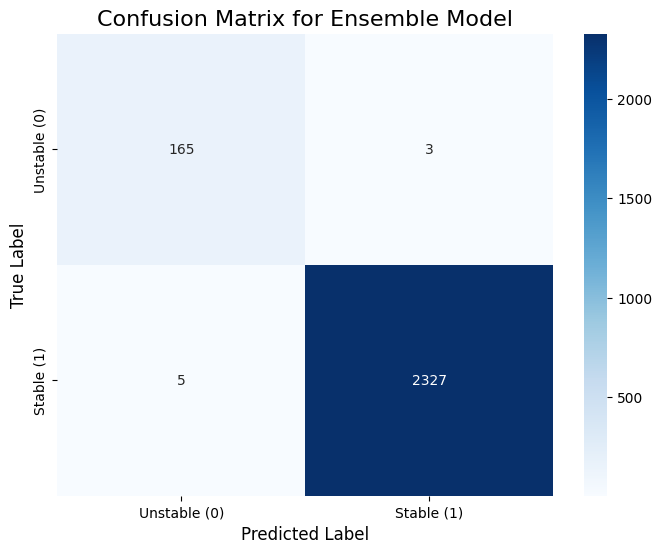

Fitting Random Forest for ROC curve...
Fitting XGBoost for ROC curve...
Fitting SVM for ROC curve...


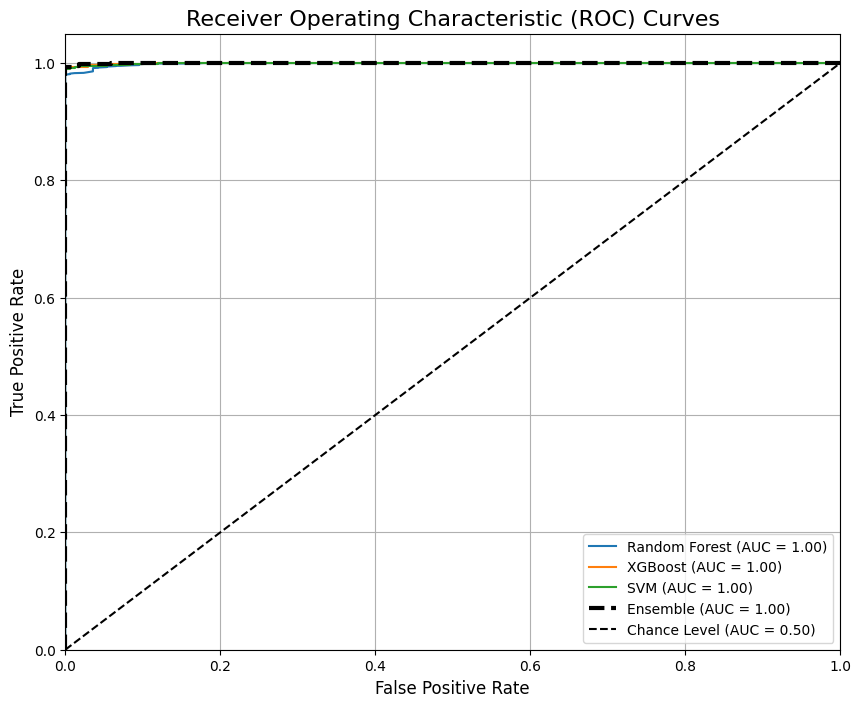

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import warnings
import re

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- 1. Data Loading and Initial Exploration ---
def load_data(filepath):
    """
    Loads the slope stability dataset from a CSV file.
    Args:
        filepath (str): The path to the CSV file.
    Returns:
        pandas.DataFrame: The loaded data.
    """
    try:
        df = pd.read_csv(filepath)
        print("Dataset loaded successfully!")
        print(f"Dataset shape: {df.shape}")
        print("\nFirst 5 rows of the dataset:")
        print(df.head())
        print("\nDataset Info:")
        df.info()
        return df
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
        print("Please ensure the dataset file is in the same directory as this script.")
        return None

# --- NEW: Data Cleaning and Preparation ---
def clean_and_prepare_data(df):
    """
    Cleans column names and creates a binary target variable.
    Args:
        df (pandas.DataFrame): The raw dataframe.
    Returns:
        pandas.DataFrame: The cleaned and prepared dataframe.
    """
    print("\nCleaning and preparing data...")
    # Standardize column names: lowercase, replace special chars with underscore
    clean_cols = []
    for col in df.columns:
        # Remove units in parentheses
        new_col = re.sub(r'\s*\([^)]*\)', '', col)
        # Replace spaces and special characters with underscores
        new_col = re.sub(r'[^a-zA-Z0-9]+', '_', new_col).lower().strip('_')
        clean_cols.append(new_col)

    df.columns = clean_cols
    print("Cleaned column names:", df.columns.tolist())

    # Create a binary classification target 'class' from 'factor_of_safety'
    # A common threshold for stability is a Factor of Safety (FS) of 1.25 or 1.5
    # We'll classify slopes with FS >= 1.25 as stable (1), and unstable (0) otherwise.
    if 'factor_of_safety' in df.columns:
        df['class'] = (df['factor_of_safety'] >= 1.25).astype(int)
        print("\nCreated binary 'class' column from 'factor_of_safety'.")
        print(df['class'].value_counts(normalize=True))
    else:
        raise KeyError("Could not find 'Factor of Safety (FS)' column to create a target variable.")

    # Drop original columns that are not needed as features
    df = df.drop(columns=['factor_of_safety', 'reinforcement_type'], errors='ignore')
    print("Dropped original 'factor_of_safety' and 'reinforcement_type' columns.")

    return df

# --- 2. Feature Engineering ---
def create_features(df):
    """
    Engineers new features based on geotechnical principles.
    Note: Assumes angle inputs are in degrees.
    Args:
        df (pandas.DataFrame): The input dataframe with cleaned features.
    Returns:
        pandas.DataFrame: The dataframe with new features added.
    """
    print("\nStarting feature engineering...")

    # Convert angles from degrees to radians for trigonometric functions
    friction_angle_rad = np.radians(df['internal_friction_angle'])
    slope_angle_rad = np.radians(df['slope_angle'])

    # Stability Index = cohesion × tan(friction_angle)
    # Adding a small epsilon to cohesion to avoid division by zero if it's used as a denominator later
    epsilon = 1e-6
    df['stability_index'] = df['cohesion'] * np.tan(friction_angle_rad)

    # Stress Ratio = (unit_weight × height) / cohesion
    df['stress_ratio'] = (df['unit_weight'] * df['slope_height']) / (df['cohesion'] + epsilon)

    # Geometric Factor = height × tan(slope_angle)
    df['geometric_factor'] = df['slope_height'] * np.tan(slope_angle_rad)

    print("Feature engineering complete. New features added:")
    print("['stability_index', 'stress_ratio', 'geometric_factor']")

    return df

# --- 3. Model Training and Evaluation ---
def train_and_evaluate(df, target_column='class'):
    """
    Preprocesses data, trains the ensemble model, and evaluates its performance.
    Args:
        df (pandas.DataFrame): The dataframe with all features.
        target_column (str): The name of the target variable column.
    """
    if target_column not in df.columns:
        print(f"Error: Target column '{target_column}' not found in the dataset.")
        return

    # Define features (X) and target (y)
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    print(f"\nData split into training ({X_train.shape[0]} samples) and testing ({X_test.shape[0]} samples) sets.")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("Features have been scaled using StandardScaler.")

    # --- Initialize Base Models ---
    print("\nInitializing base models...")
    # Random Forest
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    # XGBoost
    xgb_clf = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
    # Support Vector Machine (with probability=True for soft voting)
    svm_clf = SVC(kernel='rbf', probability=True, random_state=42)

    # --- Create the Ensemble Model (Voting Classifier) ---
    # We use 'soft' voting to leverage probability estimates from each model, which often yields better results.
    print("Creating soft voting ensemble classifier...")
    ensemble_clf = VotingClassifier(
        estimators=[('rf', rf_clf), ('xgb', xgb_clf), ('svm', svm_clf)],
        voting='soft',
        weights=[0.35, 0.35, 0.3] # Optional: give more weight to tree-based models
    )

    # --- Train the Ensemble Model ---
    print("Training the ensemble model... This may take a moment.")
    ensemble_clf.fit(X_train_scaled, y_train)
    print("Ensemble model training complete.")

    # --- Make Predictions ---
    y_pred = ensemble_clf.predict(X_test_scaled)
    y_pred_proba = ensemble_clf.predict_proba(X_test_scaled)[:, 1]

    # --- Performance Evaluation ---
    print("\n--- Model Performance Evaluation ---")

    # 1. Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nEnsemble Model Accuracy: {accuracy:.4f}")

    # 2. Classification Report (Precision, Recall, F1-Score)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # --- Visualizations ---
    # 3. Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Unstable (0)', 'Stable (1)'], yticklabels=['Unstable (0)', 'Stable (1)'])
    plt.title('Confusion Matrix for Ensemble Model', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.show()

    # 4. ROC Curve and AUC
    plt.figure(figsize=(10, 8))

    # Plot for each model in the ensemble
    models_for_roc = {'Random Forest': rf_clf, 'XGBoost': xgb_clf, 'SVM': svm_clf}
    for name, model in models_for_roc.items():
        print(f"Fitting {name} for ROC curve...")
        model.fit(X_train_scaled, y_train)
        y_pred_proba_model = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba_model)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    # Plot for the final ensemble model
    fpr_ens, tpr_ens, _ = roc_curve(y_test, y_pred_proba)
    roc_auc_ens = auc(fpr_ens, tpr_ens)
    plt.plot(fpr_ens, tpr_ens, label=f'Ensemble (AUC = {roc_auc_ens:.2f})', color='black', linewidth=3, linestyle='--')

    # Plotting details
    plt.plot([0, 1], [0, 1], 'k--', label='Chance Level (AUC = 0.50)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=16)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


# --- Main Execution ---
if __name__ == "__main__":
    # IMPORTANT: Make sure your dataset file is named 'slope_stability_data.csv'
    # and is in the same folder as this script.
    # If your file has a different name, change it below.
    dataset_path = 'slope_stability_dataset.csv'

    # Step 1: Load data
    slope_data = load_data(dataset_path)

    if slope_data is not None:
        # Step 2: Clean column names and create target variable
        slope_data_prepared = clean_and_prepare_data(slope_data)

        # Step 3: Engineer features
        slope_data_featured = create_features(slope_data_prepared)

        # Step 4: Train and evaluate the model
        train_and_evaluate(slope_data_featured, target_column='class')



Dataset loaded successfully!
Dataset shape: (10000, 9)

First 5 rows of the dataset:
   Unit Weight (kN/m³)  Cohesion (kPa)  Internal Friction Angle (°)  \
0            18.745401       21.813837                    38.249958   
1            24.507143       19.981044                    24.612800   
2            22.319939       12.926926                    28.665992   
3            20.986585       32.327000                    36.582016   
4            16.560186       26.448087                    32.052234   

   Slope Angle (°)  Slope Height (m)  Pore Water Pressure Ratio  \
0        41.907228         18.451042                   0.847237   
1        32.964623          9.266800                   0.494517   
2        58.224926         10.686165                   0.195466   
3        20.948923         13.130201                   0.736642   
4        39.392821         14.164400                   0.418678   

  Reinforcement Type  Reinforcement Numeric  Factor of Safety (FS)  
0           Drai

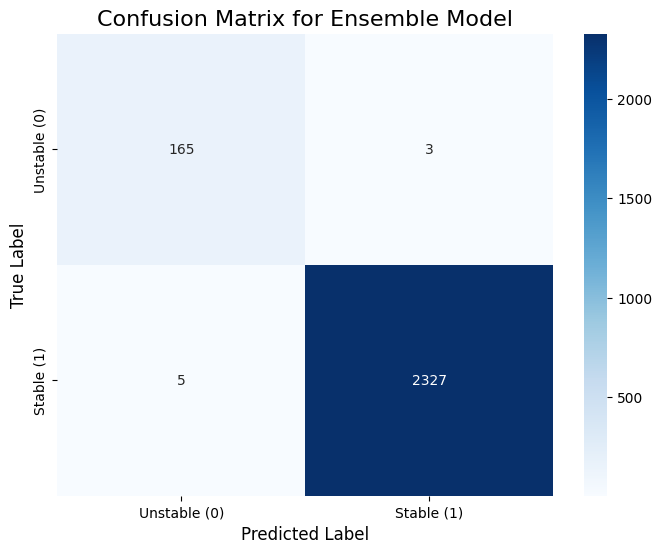

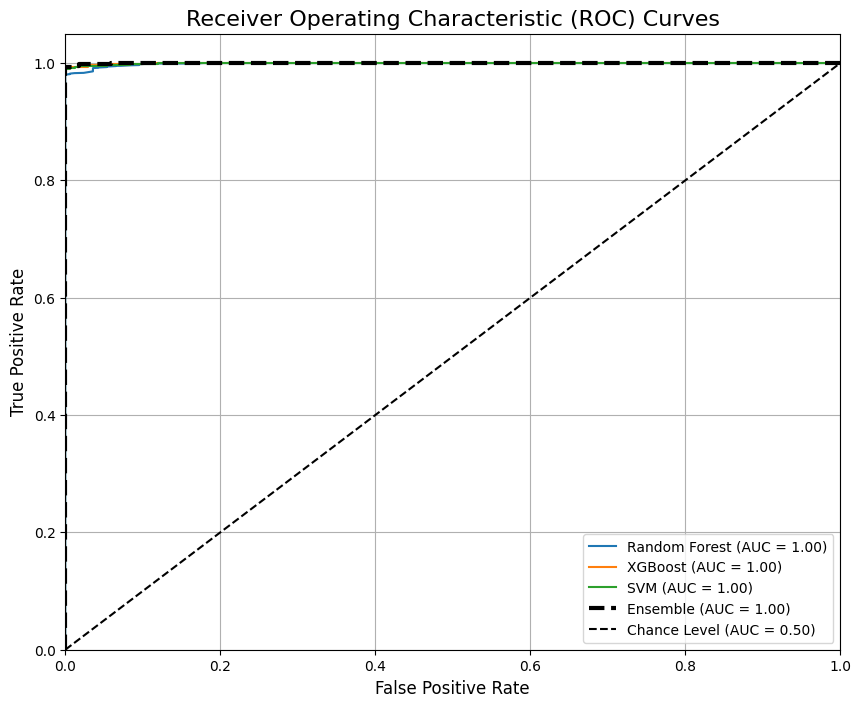


--- Predicting New Slope Stability ---

Input parameters for new slope:
   unit_weight  cohesion  internal_friction_angle  slope_angle  slope_height  \
0         20.5      15.0                       28           45          12.0   

   pore_water_pressure_ratio  reinforcement_numeric  
0                       0.25                      1  

Starting feature engineering...
Feature engineering complete.

--- Prediction Result ---
Prediction: STABLE
Confidence -> Stable: 100.00%, Unstable: 0.00%


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import warnings
import re

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- 1. Data Loading and Initial Exploration ---
def load_data(filepath):
    """
    Loads the slope stability dataset from a CSV file.
    Args:
        filepath (str): The path to the CSV file.
    Returns:
        pandas.DataFrame: The loaded data.
    """
    try:
        df = pd.read_csv(filepath)
        print("Dataset loaded successfully!")
        print(f"Dataset shape: {df.shape}")
        print("\nFirst 5 rows of the dataset:")
        print(df.head())
        print("\nDataset Info:")
        df.info()
        return df
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
        print("Please ensure the dataset file is in the same directory as this script.")
        return None

# --- Data Cleaning and Preparation ---
def clean_and_prepare_data(df):
    """
    Cleans column names and creates a binary target variable.
    Args:
        df (pandas.DataFrame): The raw dataframe.
    Returns:
        pandas.DataFrame: The cleaned and prepared dataframe.
    """
    print("\nCleaning and preparing data...")
    # Standardize column names: lowercase, replace special chars with underscore
    clean_cols = []
    for col in df.columns:
        # Remove units in parentheses
        new_col = re.sub(r'\s*\([^)]*\)', '', col)
        # Replace spaces and special characters with underscores
        new_col = re.sub(r'[^a-zA-Z0-9]+', '_', new_col).lower().strip('_')
        clean_cols.append(new_col)

    df.columns = clean_cols
    print("Cleaned column names:", df.columns.tolist())

    # Create a binary classification target 'class' from 'factor_of_safety'
    # We'll classify slopes with FS >= 1.25 as stable (1), and unstable (0) otherwise.
    if 'factor_of_safety' in df.columns:
        df['class'] = (df['factor_of_safety'] >= 1.25).astype(int)
        print("\nCreated binary 'class' column from 'factor_of_safety'.")
        print(df['class'].value_counts(normalize=True))
    else:
        raise KeyError("Could not find 'Factor of Safety (FS)' column to create a target variable.")

    # Drop original columns that are not needed as features
    df = df.drop(columns=['factor_of_safety', 'reinforcement_type'], errors='ignore')
    print("Dropped original 'factor_of_safety' and 'reinforcement_type' columns.")

    return df

# --- 2. Feature Engineering ---
def create_features(df):
    """
    Engineers new features based on geotechnical principles.
    Note: Assumes angle inputs are in degrees.
    Args:
        df (pandas.DataFrame): The input dataframe with cleaned features.
    Returns:
        pandas.DataFrame: The dataframe with new features added.
    """
    print("\nStarting feature engineering...")

    # Convert angles from degrees to radians for trigonometric functions
    friction_angle_rad = np.radians(df['internal_friction_angle'])
    slope_angle_rad = np.radians(df['slope_angle'])

    # Stability Index = cohesion × tan(friction_angle)
    epsilon = 1e-6
    df['stability_index'] = df['cohesion'] * np.tan(friction_angle_rad)

    # Stress Ratio = (unit_weight × height) / cohesion
    df['stress_ratio'] = (df['unit_weight'] * df['slope_height']) / (df['cohesion'] + epsilon)

    # Geometric Factor = height × tan(slope_angle)
    df['geometric_factor'] = df['slope_height'] * np.tan(slope_angle_rad)

    print("Feature engineering complete.")

    return df

# --- 3. Model Training and Evaluation ---
def train_and_evaluate(df, target_column='class'):
    """
    Preprocesses data, trains the ensemble model, and evaluates its performance.
    Args:
        df (pandas.DataFrame): The dataframe with all features.
        target_column (str): The name of the target variable column.
    Returns:
        tuple: A tuple containing the trained model, scaler, and feature columns.
    """
    if target_column not in df.columns:
        print(f"Error: Target column '{target_column}' not found in the dataset.")
        return None, None, None

    # Define features (X) and target (y)
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    feature_columns = X.columns

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    print(f"\nData split into training ({X_train.shape[0]} samples) and testing ({X_test.shape[0]} samples) sets.")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("Features have been scaled using StandardScaler.")

    # --- Initialize Base Models ---
    print("\nInitializing base models...")
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    xgb_clf = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
    svm_clf = SVC(kernel='rbf', probability=True, random_state=42)

    # --- Create the Ensemble Model (Voting Classifier) ---
    print("Creating soft voting ensemble classifier...")
    ensemble_clf = VotingClassifier(
        estimators=[('rf', rf_clf), ('xgb', xgb_clf), ('svm', svm_clf)],
        voting='soft',
        weights=[0.35, 0.35, 0.3]
    )

    # --- Train the Ensemble Model ---
    print("Training the ensemble model... This may take a moment.")
    ensemble_clf.fit(X_train_scaled, y_train)
    print("Ensemble model training complete.")

    # --- Make Predictions ---
    y_pred = ensemble_clf.predict(X_test_scaled)
    y_pred_proba = ensemble_clf.predict_proba(X_test_scaled)[:, 1]

    # --- Performance Evaluation ---
    print("\n--- Model Performance Evaluation ---")
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nEnsemble Model Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # --- Visualizations ---
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Unstable (0)', 'Stable (1)'], yticklabels=['Unstable (0)', 'Stable (1)'])
    plt.title('Confusion Matrix for Ensemble Model', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.show()

    plt.figure(figsize=(10, 8))
    models_for_roc = {'Random Forest': rf_clf, 'XGBoost': xgb_clf, 'SVM': svm_clf}
    for name, model in models_for_roc.items():
        model.fit(X_train_scaled, y_train)
        y_pred_proba_model = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba_model)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    fpr_ens, tpr_ens, _ = roc_curve(y_test, y_pred_proba)
    roc_auc_ens = auc(fpr_ens, tpr_ens)
    plt.plot(fpr_ens, tpr_ens, label=f'Ensemble (AUC = {roc_auc_ens:.2f})', color='black', linewidth=3, linestyle='--')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance Level (AUC = 0.50)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=16)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return ensemble_clf, scaler, feature_columns

# --- 4. NEW: Prediction Function for New Data ---
def predict_new_slope(model, scaler, feature_columns):
    """
    Predicts the stability of a new slope based on user-defined inputs.
    Args:
        model: The trained ensemble model.
        scaler: The fitted StandardScaler object.
        feature_columns (Index): The column names the model was trained on.
    """
    print("\n--- Predicting New Slope Stability ---")
    #
    # --- MODIFY YOUR INPUTS HERE ---
    #
    new_slope_data = {
        'unit_weight': [20.5],          # Example: 20.5 kN/m³
        'cohesion': [15.0],             # Example: 15.0 kPa
        'internal_friction_angle': [28],# Example: 28 degrees
        'slope_angle': [45],            # Example: 45 degrees
        'slope_height': [12.0],         # Example: 12.0 m
        'pore_water_pressure_ratio': [0.25], # Example: 0.25
        'reinforcement_numeric': [1]    # 0:Retaining Wall, 1:Soil Nailing, 2:Geosynthetics, 3:Drainage
    }

    # Create a DataFrame from the new data
    new_df = pd.DataFrame(new_slope_data)
    print("\nInput parameters for new slope:")
    print(new_df)

    # Apply the same feature engineering
    new_df_featured = create_features(new_df)

    # Ensure columns are in the same order as the training data
    new_df_aligned = new_df_featured.reindex(columns=feature_columns, fill_value=0)

    # Scale the new data
    new_data_scaled = scaler.transform(new_df_aligned)

    # Make a prediction
    prediction = model.predict(new_data_scaled)
    prediction_proba = model.predict_proba(new_data_scaled)

    # Display the result
    print("\n--- Prediction Result ---")
    if prediction[0] == 1:
        print("Prediction: STABLE")
    else:
        print("Prediction: UNSTABLE")

    print(f"Confidence -> Stable: {prediction_proba[0][1]:.2%}, Unstable: {prediction_proba[0][0]:.2%}")


# --- Main Execution ---
if __name__ == "__main__":
    dataset_path = 'slope_stability_dataset.csv'

    # Step 1: Load data
    slope_data = load_data(dataset_path)

    if slope_data is not None:
        # Step 2: Clean and prepare data
        slope_data_prepared = clean_and_prepare_data(slope_data)

        # Step 3: Engineer features
        slope_data_featured = create_features(slope_data_prepared)

        # Step 4: Train and evaluate the model
        trained_model, scaler_obj, features = train_and_evaluate(slope_data_featured, target_column='class')

        # Step 5: Predict on new user-defined data
        if trained_model:
            predict_new_slope(trained_model, scaler_obj, features)



In [ ]:
# ============================
# Rockfall Detection with YOLOv8
# ============================

# 1. Install ultralytics
!pip install ultralytics --quiet

# 2. Import YOLO
from ultralytics import YOLO
import torch

!mkdir -p /content/dataset

# 3. Unzip the data
!unzip -q /content/train.zip -d /content/dataset/
!unzip -q /content/valid.zip -d /content/dataset/
!unzip -q /content/test.zip -d /content/dataset/
!unzip -q /content/train1.zip -d /content/dataset/
!unzip -q /content/valid1.zip -d /content/dataset/
!unzip -q /content/test1.zip -d /content/dataset/
!unzip -q /content/train2.zip -d /content/dataset/
!unzip -q /content/valid2.zip -d /content/dataset/
!unzip -q /content/test2.zip -d /content/dataset/

# 3. Check GPU
print("GPU available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

# 4. Create dataset.yaml (update path if your dataset is in /content/dataset)
dataset_yaml = """
path: /content/dataset  # root dataset folder (train/valid/test inside)
train: train/images
val: valid/images
test: test/images

nc: 2
names: ['stable', 'rockfall']
"""

with open("dataset.yaml", "w") as f:
    f.write(dataset_yaml)

# 5. Load YOLOv8n model (Nano)
# You can replace 'yolov8n.pt' with 'yolov8s.pt' for higher accuracy (slower).
model = YOLO("yolov8n.pt")

# 6. Train the model
results = model.train(
    data="dataset.yaml",
    epochs=100,
    imgsz=640,
    batch=16,
    optimizer="Adam",   # Adam often generalizes better on smaller datasets
    device=0,           # use GPU
    patience=20         # early stopping if no improvement
)

# 7. Validate on validation set
metrics = model.val()
print("Validation metrics:", metrics)

# 8. Run inference on test set (results saved in /runs/detect/predict)
results = model.predict(
    source="/content/dataset/test/images",
    conf=0.25,
    save=True
)

# 9. Extract feature vectors for ensemble integration
# Feature vectors = embeddings from YOLO backbone
import torch.nn as nn

# Hook to capture intermediate layer output
features_list = []
def hook_fn(module, input, output):
    features_list.append(output.detach().cpu().numpy())

# Register hook on the last backbone layer
layer = model.model.model[-2]  # near-final layer before detection head
handle = layer.register_forward_hook(hook_fn)

# Run one inference to extract features
_ = model.predict(source="/content/dataset/test/images", conf=0.25, save=False)

# features_list now contains embeddings (can be used in ensemble models)
handle.remove()
print("Extracted feature vectors:", len(features_list))


GPU available: True
GPU: Tesla T4
Ultralytics 8.3.199 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True, patience=20, perspective=0.0, pl

RuntimeError: No valid images found in /content/dataset/valid/labels.cache. Images with incorrectly formatted labels are ignored. See https://docs.ultralytics.com/datasets for dataset formatting guidance.

In [ ]:
import os
import glob
import zipfile
import shutil

# 1. Unzip your dataset (train/valid/test)
def unzip_dataset(zip_path, extract_to="/content/dataset"):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"✅ Extracted {zip_path} to {extract_to}")

unzip_dataset("/content/train.zip", "/content/dataset/train")
unzip_dataset("/content/valid.zip", "/content/dataset/valid")
unzip_dataset("/content/test.zip", "/content/dataset/test")

# 2. Function to remap labels (0 = stable, 1 = rockfall)
def remap_labels(label_folder):
    txt_files = glob.glob(os.path.join(label_folder, "*.txt"))
    for file in txt_files:
        new_lines = []
        with open(file, "r") as f:
            for line in f:
                parts = line.strip().split()
                if not parts:
                    continue
                cls = int(parts[0])
                # remap: 0 stays 0, 1→1, 2→1, 3→1
                if cls == 0:
                    new_cls = 0
                else:
                    new_cls = 1
                parts[0] = str(new_cls)
                new_lines.append(" ".join(parts) + "\n")
        with open(file, "w") as f:
            f.writelines(new_lines)
    print(f"🔄 Remapped labels in {label_folder}")

# Apply remapping to train/valid/test labels
for split in ["train", "valid", "test"]:
    label_dir = f"/content/dataset/{split}/labels"
    if os.path.exists(label_dir):
        remap_labels(label_dir)

# 3. Create dataset.yaml for YOLOv8
yaml_content = """\
train: /content/dataset/train/images
val: /content/dataset/valid/images
test: /content/dataset/test/images

nc: 2
names: ['stable', 'rockfall']
"""

with open("dataset.yaml", "w") as f:
    f.write(yaml_content)

print("✅ dataset.yaml created")

# 4. Train YOLOv8
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # Nano model for speed

results = model.train(
    data="dataset.yaml",
    epochs=25,
    imgsz=640,
    batch=16,
    device=0  # use GPU
)


✅ Extracted /content/train.zip to /content/dataset/train
✅ Extracted /content/valid.zip to /content/dataset/valid
✅ Extracted /content/test.zip to /content/dataset/test
🔄 Remapped labels in /content/dataset/train/labels
🔄 Remapped labels in /content/dataset/valid/labels
🔄 Remapped labels in /content/dataset/test/labels
✅ dataset.yaml created
Ultralytics 8.3.199 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, io

In [ ]:
from ultralytics import YOLO

# Load the best trained weights
model = YOLO("/content/runs/detect/train4/weights/best.pt")


In [ ]:
results = model.val(split="test")


Ultralytics 8.3.199 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 930.1±0.0 MB/s, size: 70.4 KB)
val: Scanning /content/dataset/test/labels... 1 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1/1 304.2it/s 0.0s
val: New cache created: /content/dataset/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 9.6it/s 0.1s
                   all          1          1    0.00645          1     0.0452    0.00647
              rockfall          1          1    0.00645          1     0.0452    0.00647
Speed: 0.5ms preprocess, 79.9ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to /content/runs/detect/val


Random image selected: /content/dataset/train/images/-_png.rf.a0c17165c37bd3f85dd1347f7a462b28.jpg

image 1/1 /content/dataset/train/images/-_png.rf.a0c17165c37bd3f85dd1347f7a462b28.jpg: 640x640 1 rockfall, 7.2ms
Speed: 1.4ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/detect/predict8


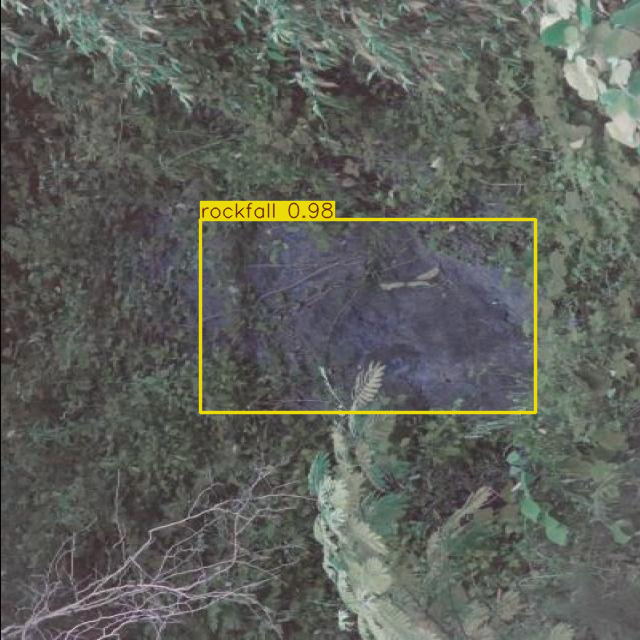

In [ ]:
import os
import random
from ultralytics import YOLO
from PIL import Image
from IPython.display import display

# 1️⃣ Path to your training images folder
train_images_folder = "/content/dataset/train/images"

# 2️⃣ List all image files
image_files = [f for f in os.listdir(train_images_folder)
               if f.lower().endswith((".jpg", ".jpeg", ".png"))]

# 3️⃣ Pick a random image
random_image = random.choice(image_files)
image_path = os.path.join(train_images_folder, random_image)
print(f"Random image selected: {image_path}")

# 4️⃣ Load the trained YOLOv8 model
model = YOLO("/content/runs/detect/train4/weights/best.pt")  # Update path if needed

# 5️⃣ Run prediction on the random image
results = model.predict(source=image_path, conf=0.5, save=True)

# 6️⃣ Display the predicted image inline (in Colab / Jupyter)
img_with_boxes = results[0].plot()  # results[0] contains predictions for the image
display(Image.fromarray(img_with_boxes))


In [ ]:
import os
import glob
import zipfile
import shutil
import cv2
import numpy as np
from pathlib import Path
import yaml
from ultralytics import YOLO
from collections import deque
import torch
from tqdm import tqdm

class RockfallDetectionSystem:
    """Advanced Rockfall Detection System with OpenCV integration"""

    def __init__(self, model_path="yolov8n.pt", device='cuda'):
        self.device = 'cuda' if torch.cuda.is_available() and device == 'cuda' else 'cpu'
        self.model = None
        self.model_path = model_path
        self.motion_buffer = deque(maxlen=5)

    # ============= Dataset Preparation =============
    @staticmethod
    def unzip_dataset(zip_path, extract_to="/content/dataset"):
        """Unzip dataset files"""
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"✅ Extracted {zip_path} to {extract_to}")

    @staticmethod
    def remap_labels(label_folder):
        """Remap labels: 0=stable, 1=rockfall"""
        txt_files = glob.glob(os.path.join(label_folder, "*.txt"))
        for file in txt_files:
            new_lines = []
            with open(file, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if not parts:
                        continue
                    cls = int(parts[0])
                    # remap: 0 stays 0, 1→1, 2→1, 3→1
                    new_cls = 0 if cls == 0 else 1
                    parts[0] = str(new_cls)
                    new_lines.append(" ".join(parts) + "\n")
            with open(file, "w") as f:
                f.writelines(new_lines)
        print(f"🔄 Remapped labels in {label_folder}")

    # ============= OpenCV Enhancement Functions =============
    @staticmethod
    def apply_clahe(image, clip_limit=2.0, tile_size=(8, 8)):
        """Apply CLAHE for contrast enhancement"""
        if len(image.shape) == 3:
            # Convert to LAB color space
            lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
            l, a, b = cv2.split(lab)

            # Apply CLAHE to L channel
            clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_size)
            l = clahe.apply(l)

            # Merge and convert back
            enhanced = cv2.merge([l, a, b])
            enhanced = cv2.cvtColor(enhanced, cv2.COLOR_LAB2BGR)
        else:
            clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_size)
            enhanced = clahe.apply(image)

        return enhanced

    @staticmethod
    def detect_edges(image, low_threshold=50, high_threshold=150):
        """Apply Canny edge detection"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
        edges = cv2.Canny(gray, low_threshold, high_threshold)
        return edges

    @staticmethod
    def enhance_image(image, apply_clahe_filter=True, sharpen=True):
        """Comprehensive image enhancement pipeline"""
        enhanced = image.copy()

        # Apply CLAHE
        if apply_clahe_filter:
            enhanced = RockfallDetectionSystem.apply_clahe(enhanced)

        # Apply sharpening
        if sharpen:
            kernel = np.array([[-1,-1,-1],
                              [-1, 9,-1],
                              [-1,-1,-1]])
            enhanced = cv2.filter2D(enhanced, -1, kernel)

        # Denoise
        enhanced = cv2.fastNlMeansDenoisingColored(enhanced, None, 10, 10, 7, 21)

        return enhanced

    def detect_motion(self, frame):
        """Detect motion between frames"""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (21, 21), 0)

        if len(self.motion_buffer) == 0:
            self.motion_buffer.append(gray)
            return None

        # Frame difference
        frame_diff = cv2.absdiff(self.motion_buffer[-1], gray)
        thresh = cv2.threshold(frame_diff, 25, 255, cv2.THRESH_BINARY)[1]

        # Dilate to fill gaps
        thresh = cv2.dilate(thresh, None, iterations=2)

        # Find contours
        contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        motion_areas = []
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > 500:  # Minimum area threshold
                x, y, w, h = cv2.boundingRect(contour)
                motion_areas.append((x, y, w, h))

        self.motion_buffer.append(gray)
        return motion_areas

    # ============= Batch Preprocessing =============
    def preprocess_dataset(self, dataset_path, enhancement_config=None):
        """Batch preprocess all images in dataset"""
        if enhancement_config is None:
            enhancement_config = {
                'apply_clahe': True,
                'sharpen': True,
                'save_enhanced': True
            }

        image_paths = glob.glob(os.path.join(dataset_path, "**/*.jpg"), recursive=True)
        image_paths.extend(glob.glob(os.path.join(dataset_path, "**/*.png"), recursive=True))

        print(f"🔄 Processing {len(image_paths)} images...")

        for img_path in tqdm(image_paths):
            img = cv2.imread(img_path)
            if img is None:
                continue

            # Apply enhancement
            enhanced = self.enhance_image(
                img,
                apply_clahe_filter=enhancement_config['apply_clahe'],
                sharpen=enhancement_config['sharpen']
            )

            if enhancement_config['save_enhanced']:
                # Save enhanced version
                base_path = Path(img_path)
                enhanced_path = base_path.parent / f"{base_path.stem}_enhanced{base_path.suffix}"
                cv2.imwrite(str(enhanced_path), enhanced)

        print("✅ Dataset preprocessing complete")

    # ============= Training Configuration =============
    def create_training_config(self, output_path="dataset.yaml"):
        """Create optimized YOLO training configuration"""
        config = {
            'train': '/content/dataset/train/images',
            'val': '/content/dataset/valid/images',
            'test': '/content/dataset/test/images',
            'nc': 2,
            'names': ['stable', 'rockfall'],

            # Advanced augmentation
            'augment': True,
            'mixup': 0.2,
            'copy_paste': 0.1,
            'mosaic': 1.0,
            'degrees': 10,
            'translate': 0.1,
            'scale': 0.5,
            'shear': 2.0,
            'perspective': 0.001,
            'flipud': 0.5,
            'fliplr': 0.5,
            'hsv_h': 0.015,
            'hsv_s': 0.7,
            'hsv_v': 0.4
        }

        with open(output_path, 'w') as f:
            yaml.dump(config, f, default_flow_style=False)

        print(f"✅ Training config created: {output_path}")
        return output_path

    def train_model(self, data_yaml="dataset.yaml", epochs=50, batch_size=16):
        """Train YOLOv8 with optimized parameters"""
        self.model = YOLO(self.model_path)

        # Optimized training parameters
        results = self.model.train(
            data=data_yaml,
            epochs=epochs,
            imgsz=640,
            batch=batch_size,
            device=self.device,

            # Optimizer settings
            optimizer='AdamW',
            lr0=0.001,
            lrf=0.01,
            momentum=0.937,
            weight_decay=0.0005,
            warmup_epochs=3.0,
            warmup_momentum=0.8,
            warmup_bias_lr=0.1,

            # Advanced training
            patience=10,  # Early stopping
            save=True,
            save_period=5,
            cache=True,  # Cache images for faster training
            workers=8,

            # Loss weights
            box=0.05,
            cls=0.5,
            dfl=1.5,

            # Augmentation (from yaml)
            augment=True,

            # Validation
            val=True,
            plots=True
        )

        print("✅ Training complete")
        return results

    # ============= Video Processing =============
    def process_video(self, video_path, output_path=None, show_preview=False,
                     enhance_frames=True, detect_motion_flag=True):
        """Process video with YOLO detection and OpenCV enhancements"""

        if self.model is None:
            self.model = YOLO(self.model_path)

        cap = cv2.VideoCapture(video_path)

        # Get video properties
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        # Setup video writer if output path specified
        if output_path:
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        frame_count = 0
        detections_log = []

        print("🎥 Processing video...")

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            frame_count += 1
            processed_frame = frame.copy()

            # Apply enhancement
            if enhance_frames:
                processed_frame = self.enhance_image(processed_frame)

            # Detect motion areas
            motion_areas = []
            if detect_motion_flag:
                motion_areas = self.detect_motion(frame)

            # Run YOLO detection
            results = self.model(processed_frame, conf=0.25, iou=0.45)

            # Process detections
            for r in results:
                boxes = r.boxes
                if boxes is not None:
                    for box in boxes:
                        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                        conf = box.conf[0].cpu().numpy()
                        cls = int(box.cls[0].cpu().numpy())

                        # Draw bounding box
                        color = (0, 255, 0) if cls == 0 else (0, 0, 255)  # Green for stable, Red for rockfall
                        cv2.rectangle(processed_frame,
                                    (int(x1), int(y1)),
                                    (int(x2), int(y2)),
                                    color, 2)

                        # Add label
                        label = f"{'Stable' if cls == 0 else 'Rockfall'}: {conf:.2f}"
                        cv2.putText(processed_frame, label,
                                  (int(x1), int(y1) - 10),
                                  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

                        # Log detection
                        detections_log.append({
                            'frame': frame_count,
                            'class': cls,
                            'confidence': conf,
                            'bbox': [x1, y1, x2, y2]
                        })

            # Draw motion areas
            if motion_areas:
                for (x, y, w, h) in motion_areas:
                    cv2.rectangle(processed_frame, (x, y), (x + w, y + h),
                                (255, 255, 0), 1)  # Yellow for motion

            # Add frame info
            info_text = f"Frame: {frame_count} | Detections: {len(detections_log)}"
            cv2.putText(processed_frame, info_text, (10, 30),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

            # Write frame
            if output_path:
                out.write(processed_frame)

            # Show preview
            if show_preview:
                cv2.imshow('Rockfall Detection', processed_frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

        # Cleanup
        cap.release()
        if output_path:
            out.release()
        cv2.destroyAllWindows()

        print(f"✅ Video processing complete. Total detections: {len(detections_log)}")
        return detections_log

    # ============= Real-time Stream Processing =============
    def process_stream(self, source=0, enhance_frames=True):
        """Process real-time video stream (webcam or RTSP)"""

        if self.model is None:
            self.model = YOLO(self.model_path)

        cap = cv2.VideoCapture(source)

        print("📹 Starting real-time detection... Press 'q' to quit")

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Apply enhancement
            if enhance_frames:
                frame = self.enhance_image(frame)

            # Run detection
            results = self.model(frame, conf=0.25, stream=True)

            # Annotate frame
            for r in results:
                annotated_frame = r.plot()

            # Display
            cv2.imshow('Real-time Rockfall Detection', annotated_frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()

    # ============= Feature Extraction =============
    def extract_features(self, image_path):
        """Extract backbone features for ensemble methods"""
        if self.model is None:
            self.model = YOLO(self.model_path)

        img = cv2.imread(image_path)
        img = self.enhance_image(img)

        # Get model predictions with features
        results = self.model(img)

        # Extract features from backbone
        features = []
        for r in results:
            if hasattr(r, 'features'):
                features.append(r.features)

        return features

    # ============= Validation & Metrics =============
    def validate_model(self, data_yaml="dataset.yaml"):
        """Comprehensive model validation"""
        if self.model is None:
            self.model = YOLO(self.model_path)

        metrics = self.model.val(data=data_yaml)

        print("\n📊 Validation Metrics:")
        print(f"mAP50: {metrics.box.map50:.4f}")
        print(f"mAP50-95: {metrics.box.map:.4f}")
        print(f"Precision: {metrics.box.p:.4f}")
        print(f"Recall: {metrics.box.r:.4f}")

        return metrics

# ============= Main Execution Script =============
def main():
    """Main execution function"""

    # Initialize system
    detector = RockfallDetectionSystem(model_path="yolov8n.pt")

    # Step 1: Prepare dataset
    print("📦 Preparing dataset...")
    detector.unzip_dataset("/content/train.zip", "/content/dataset")
    detector.unzip_dataset("/content/valid.zip", "/content/dataset")
    detector.unzip_dataset("/content/test.zip", "/content/dataset")


    # Step 2: Remap labels
    for split in ["train", "valid", "test"]:
        label_dir = f"/content/dataset/{split}/labels"
        if os.path.exists(label_dir):
            detector.remap_labels(label_dir)

    # Step 3: Preprocess dataset with OpenCV enhancements
    print("🖼️ Enhancing dataset images...")
    detector.preprocess_dataset("/content/dataset/train/images")

    # Step 4: Create training configuration
    config_path = detector.create_training_config()

    # Step 5: Train model
    print("🚀 Starting training...")
    results = detector.train_model(
        data_yaml=config_path,
        epochs=30,
        batch_size=16
    )

    # Step 6: Validate model
    print("📊 Validating model...")
    metrics = detector.validate_model(config_path)

    # Step 7: Example video processing
    # detector.process_video(
    #     video_path="path/to/video.mp4",
    #     output_path="output_annotated.mp4",
    #     enhance_frames=True,
    #     detect_motion_flag=True
    # )

    # Step 8: Example real-time processing
    # detector.process_stream(source=0, enhance_frames=True)

    print("\n✅ Complete! Model ready for deployment.")
    return detector

if __name__ == "__main__":
    detector = main()

📦 Preparing dataset...
✅ Extracted /content/train.zip to /content/dataset
✅ Extracted /content/valid.zip to /content/dataset
✅ Extracted /content/test.zip to /content/dataset
🔄 Remapped labels in /content/dataset/train/labels
🔄 Remapped labels in /content/dataset/valid/labels
🔄 Remapped labels in /content/dataset/test/labels
🖼️ Enhancing dataset images...
🔄 Processing 867 images...


100%|██████████| 867/867 [17:39<00:00,  1.22s/it]

✅ Dataset preprocessing complete
✅ Training config created: dataset.yaml
🚀 Starting training...
Ultralytics 8.3.200 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=0.05, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimi

Model summary: 129 layers, 3,011,238 parameters, 3,011,222 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2182.7±536.0 MB/s, size: 204.9 KB)
train: Scanning /content/dataset/train/labels... 867 images, 882 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1734/1734 3.1Kit/s 0.6s
train: New cache created: /content/dataset/train/labels.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.
train: Caching images (2.0GB RAM): 100% ━━━━━━━━━━━━ 1734/1734 198.5it/s 8.7s
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (p

Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 270, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 427, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 384, in _send
    n = write(self._handle, buf)
        ^^^^^^^^^^^^^^^^^^^^^^^^
OSError: [Errno 9] Bad file descriptor
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exc

✅ Training complete
📊 Validating model...
Ultralytics 8.3.200 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1011.5±739.1 MB/s, size: 82.2 KB)
val: Scanning /content/dataset/valid/labels.cache... 4 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 4/4 7.4Kit/s 0.0s
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.
val: Caching images (0.0GB RAM): 100% ━━━━━━━━━━━━ 4/4 324.7it/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 4.6it/s 0.2s
                   all          4          4      0.489       0.75      0.376      0.173
              rockfall          4          4      0.489       0.75      0.376      0.173
Speed: 2.5ms preprocess, 39.9ms inference, 0.0ms loss, 1.2ms p

TypeError: unsupported format string passed to numpy.ndarray.__format__

In [ ]:
import os
import glob
import zipfile
import shutil

# 1. Unzip your dataset (train/valid/test)
def unzip_dataset(zip_path, extract_to="/content/dataset"):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"✅ Extracted {zip_path} to {extract_to}")

unzip_dataset("/content/train.zip", "/content/dataset/train")
unzip_dataset("/content/valid.zip", "/content/dataset/valid")
unzip_dataset("/content/test.zip", "/content/dataset/test")

# 2. Function to remap labels (0 = stable, 1 = rockfall)
def remap_labels(label_folder):
    txt_files = glob.glob(os.path.join(label_folder, "*.txt"))
    for file in txt_files:
        new_lines = []
        with open(file, "r") as f:
            for line in f:
                parts = line.strip().split()
                if not parts:
                    continue
                cls = int(parts[0])
                # remap: 0 stays 0, 1→1, 2→1, 3→1
                if cls == 0:
                    new_cls = 0
                else:
                    new_cls = 1
                parts[0] = str(new_cls)
                new_lines.append(" ".join(parts) + "\n")
        with open(file, "w") as f:
            f.writelines(new_lines)
    print(f"🔄 Remapped labels in {label_folder}")

# Apply remapping to train/valid/test labels
for split in ["train", "valid", "test"]:
    label_dir = f"/content/dataset/{split}/labels"
    if os.path.exists(label_dir):
        remap_labels(label_dir)

# 3. Create dataset.yaml for YOLOv8
yaml_content = """\
train: /content/dataset/train/images
val: /content/dataset/valid/images
test: /content/dataset/test/images

nc: 2
names: ['stable', 'rockfall']
"""

with open("dataset.yaml", "w") as f:
    f.write(yaml_content)

print("✅ dataset.yaml created")

# 4. Train YOLOv8 (optimized for real-time deployment)
from ultralytics import YOLO

# ✅ Create YOLO model (nano/small for real-time)
model = YOLO("yolov8n.pt")  # use yolov8s.pt if GPU is strong enough

# ✅ Training parameters optimized for real-time video use
results = model.train(
    data="dataset.yaml",
    epochs=50,              # more epochs for better convergence
    batch=32,               # larger batch for speed if GPU allows
    imgsz=640,              # can reduce to 416 for faster inference
    device=0,               # use GPU
    workers=2,              # lower workers for Colab stability
    optimizer="AdamW",      # AdamW is stable for small models
    lr0=0.002,              # slightly lower learning rate
    cos_lr=True,            # cosine annealing for smoother convergence
    amp=True,               # mixed precision (faster)
    cache=True              # cache dataset in RAM
)


✅ Extracted /content/train.zip to /content/dataset/train
✅ Extracted /content/valid.zip to /content/dataset/valid
✅ Extracted /content/test.zip to /content/dataset/test
🔄 Remapped labels in /content/dataset/train/labels
🔄 Remapped labels in /content/dataset/valid/labels
🔄 Remapped labels in /content/dataset/test/labels
✅ dataset.yaml created
Ultralytics 8.3.200 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=

Random image selected: unified_dataset/test/images/test_19_-_png.rf.b1a0a5291f38ed451d090b4e589cb483.jpg

image 1/1 /content/unified_dataset/test/images/test_19_-_png.rf.b1a0a5291f38ed451d090b4e589cb483.jpg: 640x640 1 rockfall, 7.1ms
Speed: 2.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/detect/predict39


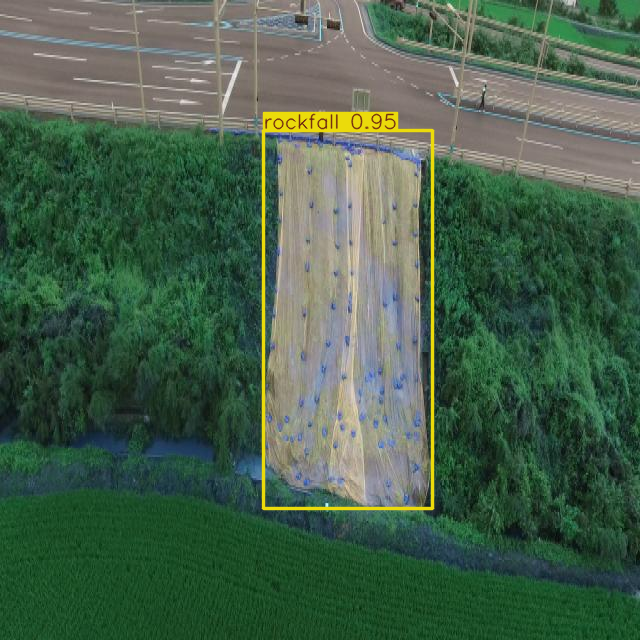

In [ ]:
import os
import random
from ultralytics import YOLO
from PIL import Image
from IPython.display import display

# 1️⃣ Path to your training images folder
train_images_folder = "unified_dataset/test/images"

# 2️⃣ List all image files
image_files = [f for f in os.listdir(train_images_folder)
               if f.lower().endswith((".jpg", ".jpeg", ".png"))]

# 3️⃣ Pick a random image
random_image = random.choice(image_files)
image_path = os.path.join(train_images_folder, random_image)
print(f"Random image selected: {image_path}")

# 4️⃣ Load the trained YOLOv8 model
model = YOLO("/content/runs/detect/train6/weights/best.pt")  # Update path if needed

# 5️⃣ Run prediction on the random image
results = model.predict(source=image_path, conf=0.5, save=True)

# 6️⃣ Display the predicted image inline (in Colab / Jupyter)
img_with_boxes = results[0].plot()  # results[0] contains predictions for the image
display(Image.fromarray(img_with_boxes))
